In [1]:
import os

os.environ["OMP_NUM_THREADS"] = '12'

import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn
import torch.nn.functional as F
import dgl
import os.path as osp
import GCL.losses as L
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import scipy.sparse as sp

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam
from GCL.eval import get_split, LREvaluator, SVMEvaluator
from GCL.models import SingleBranchContrast

from scipy.io import loadmat
from GCL.models.contrast_model import WithinEmbedContrast
from dgl.nn.pytorch import GATConv, GraphConv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from GCL.models import DualBranchContrast

from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_adj
from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_feature

In [2]:
class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = self.act(z)

        return F.normalize(z, dim=1)


class Encoder(nn.Module):
    def __init__(self, graph_dict, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()

        gconvs = nn.ModuleDict()
        self.cluster_projectors = nn.ModuleDict()
        self.instance_projectors = nn.ModuleDict()

        for k, v in graph_dict.items():
            gconv = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers).to(device)
            gconvs[k] = gconv
            self.cluster_projectors[k] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, n_clusters),
                nn.Softmax(dim=1)
            )
            self.instance_projectors[k] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
        self.encoder = gconvs
        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5
        self.reset_parameters(graph_dict)

    def reset_parameters(self, graph_dict):
        for k, v in graph_dict.items():
            for m in self.cluster_projectors[k]:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
            for m in self.instance_projectors[k]:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)

    def forward(self, x, graph_dict, edge_weight=None):
        aug1, aug2 = self.augmentor
        zs = []
        z1s = []
        z2s = []
        c1s = []
        c2s = []
        for key, (graph, edge_index) in graph_dict.items():
            z = self.encoder[key](x, graph)

            x1, edge_index1, _ = aug1(x, edge_index)
            graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
            z1 = self.encoder[key](x1, graph1)

            x2, edge_index2, _ = aug2(x, edge_index)
            graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
            z2 = self.encoder[key](x2, graph2)

            c1 = self.cluster_projectors[key](z1)
            c2 = self.cluster_projectors[key](z2)

            z1 = self.instance_projectors[key](z1)
            z2 = self.instance_projectors[key](z2)

            zs.append(z)
            z1s.append(z1)
            z2s.append(z2)
            c1s.append(c1)
            c2s.append(c2)

        zs = torch.stack(zs)
        z1s = torch.stack(z1s)
        z2s = torch.stack(z2s)
        c1s = torch.stack(c1s)
        c2s = torch.stack(c2s)
        return zs, z1s, z2s, c1s, c2s

    def cluster(self, x, graph_dict, edge_weight=None):
        zs = []
        cs = []
        for key, (graph, edge_index) in graph_dict.items():
            z = self.encoder[key](x, graph)
            c = self.cluster_projectors[key](z)

            zs.append(z)
            cs.append(c)

        return zs, cs


In [3]:
def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


In [4]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))

path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [5]:
print(len(mat['train_idx'][0]))

600


In [6]:
def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


graph_dict = {}
for etype in ['PAP', 'PLP']:
    # for etype in ['net_APCPA', 'net_APTPA', 'net_APA']:
    # for etype in ['net_APCPA', 'net_APA']:
    # for etype in ['MDM', 'MAM']:
    adj = load_graph(mat[etype]).to(device)
    graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat[etype])).to(device)
    graph.remove_self_loop()
    graph.add_self_loop()
    edge_index = torch.stack(graph.edges())
    graph_dict[etype] = (graph, edge_index)

In [7]:
print(graph_dict)

{'PAP': (Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,    8,   20,  ..., 2983, 2991, 3024]], device='cuda:0')), 'PLP': (Graph(num_nodes=3025, num_edges=2210761,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,   75,  434,  ..., 3021, 3022, 3024]], device='cuda:0'))}


In [8]:
from sklearn.decomposition import PCA

x = tensor(mat['feature'], dtype=torch.float).to(device)
# pca = PCA(n_components=0.90)
# x = pca.fit_transform(mat['features'])
# x = tensor(x, dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)


In [9]:
del mat


model have 1487622 paramerters in total


(T): 0it [00:00, ?it/s]
(T): 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.32it/s, loss=12.4, con_loss=11.7, clu_loss=0.724]


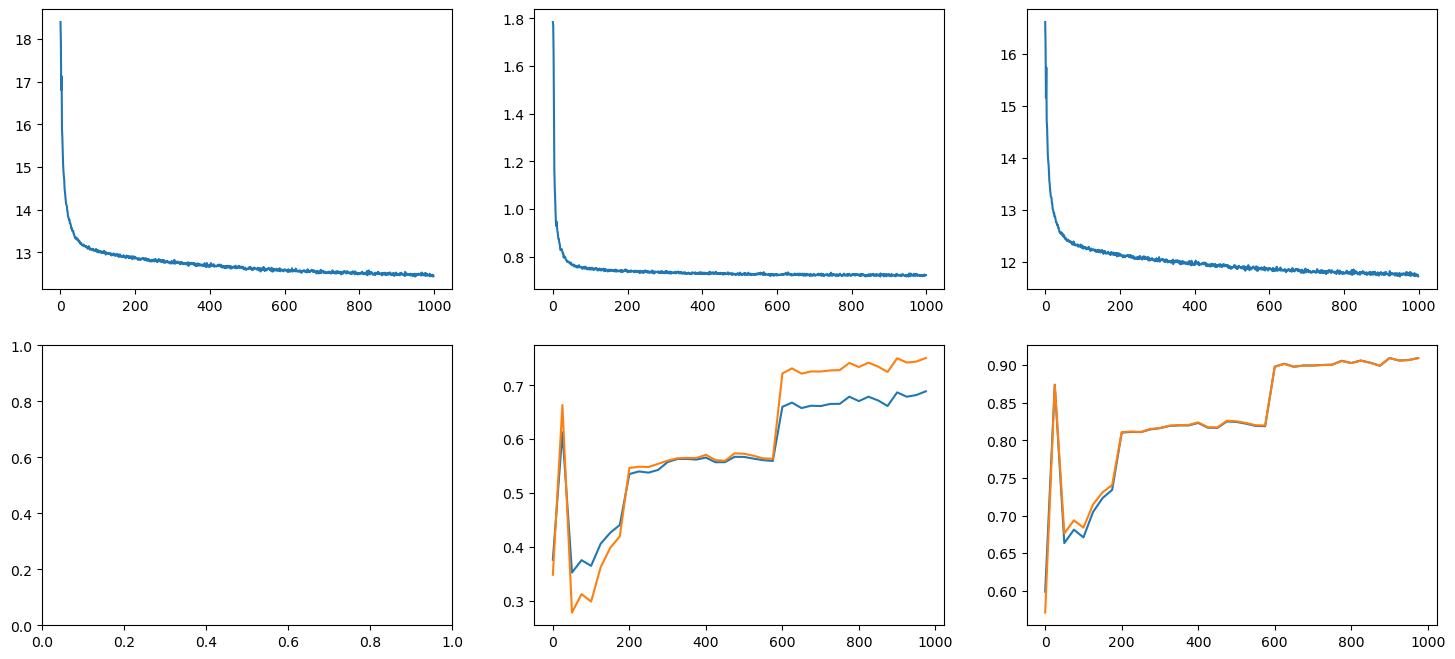

[MAX]NMI:  0.6888010107490279
[MAX]ARI:  0.7505289018541603
[MAX]ACC:  0.9094214876033058
[MAX]F1:  0.9092680950573327


In [25]:


def train1(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x, graph_dict):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, c1s, c2s = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])
    # for i in range(len(z1s)):
    #     con_loss += contrast_model2(z1s[i], z2s[int((i + 1) % len(z1s))])
    # con_loss += contrast_model2(z1s[0], z2s[1])
    loss = con_loss

    loss.backward()
    optimizer.step()

    return loss.item(), con_loss.item()


def train2(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x, graph_dict):
    encoder_model.train()
    optimizer.zero_grad()
    zs, z1s, z2s, c1s, c2s = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])
    # for i in range(len(z1s)):
    #     con_loss += contrast_model2(z1s[i], z2s[int((i + 1) % len(z1s))])
    # for i in range(1, len(z1s)):
    #     con_loss += contrast_model2(z1s[0], z1s[i])
    #     con_loss += contrast_model2(z2s[0], z2s[i])
    # con_loss += contrast_model2(z1s[0], z2s[1])
    for i in range(1, len(z1s)):
        con_loss += F.mse_loss(zs[0], zs[i])
        # con_loss += F.mse_loss(z2s[0], z2s[i])
    clu_loss = 0
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i].t(), c2s[i].t())
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])
    clu_loss += cluster_model(c1s[0].t(), c2s[0].t())
    loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


aug1 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.5)])
# aug1 = A.Identity()
aug2 = A.Compose([A.EdgeRemoving(pe=0.3), A.FeatureDropout(pf=0.5)])

encoder_model = Encoder(graph_dict=graph_dict, augmentor=(aug1, aug2), hidden_dim=256, num_heads=1, n_clusters=3,
                        num_layers=2).to(device)
print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model2 = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=False).to(device)
# contrast_model2 = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
cluster_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer1 = Adam(encoder_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = Adam(encoder_model.parameters(), lr=0.003, weight_decay=1e-5)
losss = []
clu_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs1 = 0
epochs2 = 1000

kmeans = KMeans(n_clusters=3, n_init=20)

with tqdm(total=epochs1, desc='(T)') as pbar:
    for epoch in range(epochs1):
        encoder_model.train()

        loss, con_loss = train1(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer1, x,
                                graph_dict)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss})
        pbar.update()

with tqdm(total=epochs2, desc='(T)') as pbar:
    for epoch in range(epochs2):
        encoder_model.train()

        loss, con_loss, clu_loss = train2(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x,
                                          graph_dict)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'clu_loss': clu_loss})
        pbar.update()
        losss.append(loss)
        clu_losss.append(clu_loss)
        con_losss.append(con_loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                zs, _, _, _, _ = encoder_model(x, graph_dict)
            # z = torch.cat((zs[0], zs[1]), dim=1)
            z = zs[0]
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs2), losss)
axes[0][1].plot(range(epochs2), clu_losss)
axes[0][2].plot(range(epochs2), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


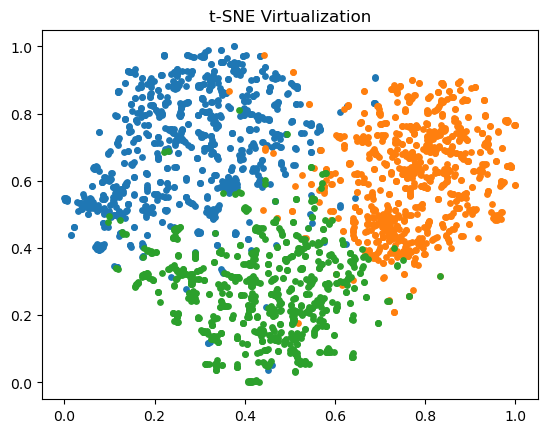

In [26]:

from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict, edge_index)
    # z = torch.cat((zs[0], zs[1]), dim=1)
    z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()



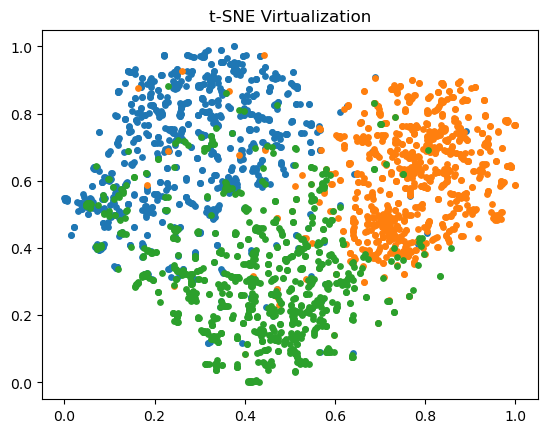

In [27]:
d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [28]:
with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = torch.cat((zs[0], zs[1]), dim=1)
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z0', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z1', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0] + zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, cs = encoder_model.cluster(x, graph_dict)
    pred = torch.argmax(cs[0], -1).cpu().numpy()
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

0.5547786804256933 0.5606195286564112 0.8099173553719008 0.8118612982655717
z0 0.7399347343297052 0.6780954469739415 0.9051239669421488 0.9049449857231808
z1 0.4267786560766652 0.45678031315543993 0.6978512396694215 0.7015214806387907
0.5188446227213329 0.5459502303596911 0.7775206611570248 0.7771300325969827
0.14176750253945944 0.2601851522104851 0.5626446280991736 0.5670271828603869


In [29]:

z = torch.cat((zs[0], zs[1]), dim=1)
print(z.size())

torch.Size([3025, 512])
